In [2]:
# This code compares triple-for loop and flat von neimann neighbours implementations
# and tests if this 2 methods gives the same result
# also test that 460 instead of 512 on 0-axis

# firstly i remove this condition:
            # if ro[i, j, k] < 0.1 and i != A and j != B and k != C: # refl􏰂ecting condition | use numpy masking
                # P[i, j, k] = 0

import numpy as np
from time import time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # 10 x 10 inches plot

In [55]:
# N = 8
# S = 6 # number of slices / CT-images / scans
r = np.load('3d_numpy_array_reduced-58-64-64.npy')
# r = np.random.random((S, N, N))
# r = np.random.random((S, N, N))**2
# r = np.load('r.npy')
ro  = 1e-5 + 1.24e-3*r - 2.83e-7*r*r + 2.79e-11*r*r*r
c = (ro + 0.112) * 1.38e-6

# тут не факт что все 1
l = 1 # dt
h = 1 # dx = dy = dz

K = l / h * c
K2 = K**2
K_2_by_3 = K**2 / 3
# K2_3_ro = K2 / 3 / ro


# initial conditions
P_pp = np.zeros_like(ro) # previous previous t - 2
P_p  = np.zeros_like(ro) # previous          t - 1
P    = np.zeros_like(ro) # current           t
# P_pp = np.zeros((S, N, N)) # previous previous t - 2
# P_p  = np.zeros((S, N, N)) # previous          t - 1
# P    = np.zeros((S, N, N)) # current           t
# P_pp = np.random.random((S, N, N)) # previous previous t - 2
# P_p  = np.random.random((S, N, N)) # previous          t - 1
# P    = np.random.random((S, N, N)) # current           t

# P_pp = np.arange(N**3).reshape(N, N, N) * 10.
# P_p = np.arange(N**3).reshape(N, N, N) * 12.
# P_pp = np.load('P_pp.npy')
# P_p = np.load('P_p.npy')
# P    = np.zeros((S, N, N), dtype=np.float64) # current           t

# np.save('P_pp.npy', P_pp)
# np.save('P_p.npy', P_p)
# np.save('r.npy', r)
# print(r.mean(), ro > 0.1)

In [56]:
print(r.max(), r.min())
# print(P.max(), P.min())

2716 0


In [57]:
def P_step(P_pp, P_p):
    '''
    mb work with flat and then reshape in return
    norm by now, mb add some more optimisations in future, also cuda
    '''

    S = P_p.shape[0]
    N = P_p.shape[1]

    P[2:-2, 2:-2, 2:-2] = 2 * P_p[2:-2, 2:-2, 2:-2] - P_pp[2:-2, 2:-2, 2:-2]
    Z = np.zeros_like(P_p)
    Z[2:-2, 2:-2, 2:-2] = 22.5 * P_p[2:-2, 2:-2, 2:-2]
    
    bound_sum = np.sum(P[:2])
    if(bound_sum != 0):
        print(f'bug police1: {bound_sum}')

    cell_indeces_flat = np.arange(S * N * N).reshape(S, N, N)[2:-2, 2:-2, 2:-2].flatten().reshape(-1, 1) # vertical vector

    s1_indexes_flat = cell_indeces_flat + np.array([-1, 1, -N, N, -N**2, N**2])      # i±1 j±1 k±1 
    s2_indexes_flat = cell_indeces_flat + np.array([-1, 1, -N, N, -N**2, N**2]) * 2  # i±2 j±2 k±2 
    s1_values = P_p.flatten()[s1_indexes_flat] # each row contains 6 neighbors of cell 
    s2_values = P_p.flatten()[s2_indexes_flat] # each row contains 6 neighbors of cell 
    s1 = np.sum(s1_values, axis=1) # sum by axis=1 is faster for default order
    s2 = np.sum(s2_values, axis=1)

    Z[2:-2, 2:-2, 2:-2] -=   4 * s1.reshape(S-4, N-4, N-4)
    Z[2:-2, 2:-2, 2:-2] += 1/4 * s2.reshape(S-4, N-4, N-4)

    bound_sum = np.sum(P[:2])
    if(bound_sum != 0):
        print(f'bug police2: {bound_sum}')

    m1 = np.array([1, -1, -1/8, -1/8])
    m2 = np.array([1, -1])

    s3_V_indexes = cell_indeces_flat + np.array([N**2, -N**2, 2*N**2, -2*N**2])
    s3_V_values = P_p.flatten()[s3_V_indexes] * m1 # po idee mozhno za skobki kak to vinesti m1 i m2
    print(P_p.max())
    s3_V_sum = np.sum(s3_V_values, axis=1)
    s3_N_indexes = cell_indeces_flat + np.array([N**2, -N**2])
    s3_N_values = ro.flatten()[s3_N_indexes] * m2
    s3_N_sum = np.sum(s3_N_values, axis=1)
    s3 = (s3_V_sum / s3_N_sum).reshape(S-4, N-4, N-4)
#     print(s3_V_sum.max(), s3_V_sum.min())
#     print(s3_V_sum)
    
    s4_V_indexes = cell_indeces_flat + np.array([N, -N, 2*N, -2*N])
    s4_V_values = P_p.flatten()[s4_V_indexes] * m1
    s4_V_sum = np.sum(s4_V_values, axis=1)
    s4_N_indexes = cell_indeces_flat + np.array([N, -N])
    s4_N_values = ro.flatten()[s4_N_indexes] * m2
    s4_N_sum = np.sum(s4_N_values, axis=1)
    s4 = (s4_V_sum / s4_N_sum).reshape(S-4, N-4, N-4)
#     print(s4_V_sum.max(), s4_V_sum.min())

    s5_V_indexes = cell_indeces_flat + np.array([1, -1, 2, -2])
    s5_V_values = P_p.flatten()[s5_V_indexes] * m1
    s5_V_sum = np.sum(s5_V_values, axis=1)
    s5_N_indexes = cell_indeces_flat + np.array([1, -1])
    s5_N_values = ro.flatten()[s5_N_indexes] * m2
    s5_N_sum = np.sum(s5_N_values, axis=1)
    s5 = (s5_V_sum / s5_N_sum).reshape(S-4, N-4, N-4)
#     print(s5_V_sum.max(), s5_V_sum.min())
    
    bound_sum = np.sum(P[:2])
    if(bound_sum != 0):
        print(f'bug police3: {bound_sum}')

    Z[2:-2, 2:-2, 2:-2] += (s3 + s4 + s5) * ro[2:-2, 2:-2, 2:-2]
    
    bound_sum = np.sum(P[:2])
    if(bound_sum != 0):
        print(f'bug police4: {bound_sum}')
    
    P[2:-2, 2:-2, 2:-2] -= Z[2:-2, 2:-2, 2:-2] * K_2_by_3[2:-2, 2:-2, 2:-2]
#     P -= Z * K_2_by_3

    bound_sum = np.sum(P[:2])
    if(bound_sum != 0):
        print(f'bug police5: {bound_sum}')

    P[ro < 0.1] = 0
    
    bound_sum = np.sum(P[:2])
    if(bound_sum != 0):
        print(f'bug police0: {bound_sum}')
#     return P[2:-2, 2:-2, 2:-2] # should return array of shape (S, N, N)
#     print(np.mean(P))
#     print(f'bug police4: {np.sum(P[:2])}') # for some reason outside boundaries != 0. P_step() should affect only inner slice of array [2:-2, 2:-2, 2:-2]
    return P

In [59]:
N = P.shape[1]
steps = 1
img = np.zeros((steps, N))

A, B, C = 0, N//2, N//2 # sound source location

f = 440
T = np.linspace(0, 2, steps)
soundwave = np.sin(2 * np.pi * f * T)
propagated = np.zeros_like(soundwave)


for i, s in enumerate(soundwave):
    P_old = P
    
    P     = P_step(P_pp, P_p)
    P[A, B, C] = s
    propagated[i] = P[-3, N//2, N//2] # location of 
#     print(P[-3])

    P_pp  = P_p
    P_p   = P_old

nan


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


In [31]:
print(P.max(), P.min())

nan nan


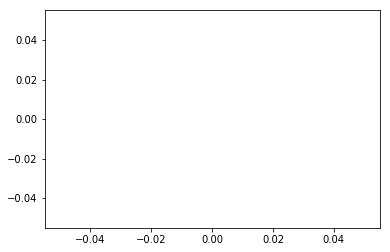

In [17]:
plt.plot(T, soundwave,'b')
plt.plot(T, propagated,'r')
plt.show()

---

---

---

# Test

In [5]:
# A = np.array([1])
# B = np.array([1])
# C = np.array([1])
A, B, C = 1, 1, 1
print('A\tB\tC')
print(A, B, C, sep='\t')
for i in range(10):
    C_old = C
    
    C = A + B
    A = B
    B = C_old
    print(A, B, C, sep='\t')

A	B	C
1	1	1
1	1	2
1	2	2
2	2	3
2	3	4
3	4	5
4	5	7
5	7	9
7	9	12
9	12	16
12	16	21


# numpy masking for re􏰦flecting condition
re􏰦flecting condition (includes all boundaries):
$$\large\rho(\mathbf{x}, t) = 0,\quad \textrm{if} \quad \rho(\mathbf{x}) < 0.1 \textrm{g/cc},\quad \mathbf{x} = [x, y, z]$$

In [6]:
rho = np.array([0.13, 0.2, 0.01, 0.4, 0.03, 0, 0.9])
p   = np.array([   1,   2,    3,   4,    5, 6,   7])

In [7]:
p[rho < 0.1]

array([3, 5, 6])

In [8]:
p[rho < 0.1] = 0

# check if boundaries `== 0`

In [9]:
x = np.random.randint(1, 5,size=(8, 8))
x[:2]

array([[1, 2, 4, 3, 1, 4, 4, 2],
       [4, 4, 1, 2, 4, 4, 2, 1]])

In [10]:
x = np.array([1, 2, 1, 1, 1, 3, 3, 3])
x[:2] = 0
x

array([0, 0, 1, 1, 1, 3, 3, 3])

# Fool Around

In [23]:
x = np.zeros((6,6))
y = np.ones((6,6))
z = np.zeros_like(x)
z[2:-2, 2:-2] = x[2:-2, 2:-2] + y[2:-2, 2:-2]
z

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [12]:
d = np.ones(4) / np.array([1,1,0,1])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [16]:
d == np.Inf

array([False, False,  True, False])